# Análisis de la red de *tweets* y usuarios relacionados con la final de la Liga Uruguaya de Basketball (LUB).






## Trabajo final del curso "De las redes complejas a las redes sociales: Introducción al Uso del Big Data"


### Integrantes del equipo: 

- Andrea Apolaro
- Guzmán López
- Leticia Vidal
- Ricardo Rezzano


## Introducción

En el marco del curso ...



## Metodología

Se utilizó el lenguaje de programación Python (versión 3.6.1) ...

### Importar librerías 

In [1]:
# Import python libraries
import tweepy
import time
from random import choice
from py2neo import authenticate, Graph
import cypher
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Autenticación de Twitter y Neo4j mediante la lectura de un archivo externo con las claves requeridas:

In [8]:
import tweepy

# Twitter OAuthentication
consumer_key = "XXXXXXXXXX"
consumer_secret = "XXXXXXXXXX"
access_token = "XXXXXXXXXX"
access_token_secret = "XXXXXXXXXX"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Neo4j
neo4jUser = "xxxx"
neo4jPass = "xxxx"

In [2]:
# Authentication credentials for Tweeter and Neo4j credentials
with open('/home/guzman/Documentos/Cursos/Redes Complejas - Introducción al uso del Big Data/Python/twitter-OAuth.py') as oauth:
    exec(oauth.read())

### Crear la API (Application Program Interface) de Twitter:

In [10]:
# Create API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

### Comenzar el servicio de la base de datos Neo4j desde una consola:

In [3]:
%%sh

# Start neo4j service 
systemctl start neo4j.service

# Check status of neo4j service
systemctl status neo4j.service

● neo4j.service - Neo4j
   Loaded: loaded (/usr/lib/systemd/system/neo4j.service; disabled; vendor preset: disabled)
   Active: active (running) since Wed 2017-06-07 13:22:51 -03; 4ms ago
  Process: 2687 ExecStart=/usr/bin/neo4j start (code=exited, status=0/SUCCESS)
 Main PID: 2747 (java)
    Tasks: 37 (limit: 4915)
   Memory: 22.2M
      CPU: 130ms
   CGroup: /system.slice/neo4j.service
           └─2747 /usr/sbin/java -cp /usr/share/java/neo4j/plugins:/etc/neo4j:/usr/share/java/neo4j/*:/usr/share/java/neo4j/plugins/* -server -XX:+UseG1GC -XX:-OmitStackTraceInFastThrow -XX:hashCode=5 -XX:+AlwaysPreTouch -XX:+UnlockExperimentalVMOptions -XX:+TrustFinalNonStaticFields -XX:+DisableExplicitGC -Djdk.tls.ephemeralDHKeySize=2048 -Dunsupported.dbms.udc.source=tarball -Dfile.encoding=UTF-8 org.neo4j.server.CommunityEntryPoint --home-dir=/usr/share/neo4j --config-dir=/etc/neo4j

jun 07 13:22:51 carqueja systemd[1]: Starting Neo4j...
jun 07 13:22:51 carqueja neo4j[2687]: Starting Neo4j.
jun 07 1

### Autenticación de la base de datos no relacional Neo4j a través de la lectura del archivo externo con las claves de usuario y contraseña requeridas leído anteriormente.

In [5]:
# Neo4j DB graph authentication

# Connect to graph
url = "http://localhost:7474/db/data/"
authenticate("localhost:7474", neo4jUser, neo4jPass)
graph = Graph(url)

# Authentication for cypher package
connPar = "http://" + neo4jUser + ":" + neo4jPass + "@localhost:7474/db/data/"

### Agregar restricciones de unicidad a la base de datos:

In [ ]:
# Add uniqueness constraints
graph.run("CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.screen_name IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (l:Link) ASSERT l.url IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (s:Source) ASSERT s.name IS UNIQUE;")

### Construir una lista con las palabras clave para la búsqueda de tweets:

In [16]:
# Query words
queries = ["aguada", "aguatero", "hebraica", "macabi", "finalesLUB", "juntosporlanovena", "vamossha", "finaleslub"]

### Crear un archivo de texto vacío para adjuntar (escribir) los nombres de los usuarios de los tweets encontrados:

In [ ]:
# Open file connection to append usernames
ufile = open("usernames_{}.txt".format("aguada-hebraica"), "a")

### Cargar script de comandos en Cypher como cadena de caracteres

In [6]:
# Pass dict to Cypher and build query from cypher script file
with open('/home/guzman/Documentos/GitLab/ComplexNetworks/Cypher/queries-in-script.cypher') as query:
    query = query.read()

print(query)

UNWIND {tweets} AS t

WITH t
ORDER BY t.id

WITH t,
t.entities AS e,
t.user AS u,
t.retweeted_status AS retweet

MERGE (tweet:Tweet {id:t.id})
SET tweet.text = t.text,
tweet.created_at = t.created_at,
tweet.favorites = t.favorite_count

MERGE (user:User {screen_name:u.screen_name})
SET user.name = u.name,
user.location = u.location,
user.followers = u.followers_count,
user.following = u.friends_count,
user.statuses = u.statuses_count,
user.profile_image_url = u.profile_image_url

MERGE (user)-[:POSTS]->(tweet)

MERGE (source:Source {name:t.source})
MERGE (tweet)-[:USING]->(source)

FOREACH (h IN e.hashtags |
  MERGE (tag:Hashtag {name:LOWER(h.text)})
  MERGE (tag)-[:TAGS]->(tweet)
  )

  FOREACH (u IN e.urls |
    MERGE (url:Link {url:u.expanded_url})
    MERGE (tweet)-[:CONTAINS]->(url)
    )

    FOREACH (m IN e.user_mentions |
      MERGE (mentioned:User {screen_name:m.screen_name})
      ON CREATE SET mentioned.name = m.name
      MERGE (tweet)-[:MENTIONS]->(mentioned)
      )

   

### Definir los parámetros para la búsqueda de los tweets:

In [ ]:
# Parameters
count = 100 # The number of tweets to return per page, up to a maximum of 100. Defaults to 15.
result_type = "mixed" # Include both popular and real time results in the response.
until = "2017-06-04" # Returns tweets created before the given date.
lang = "es" # Restricts tweets to the given language
since_id = -1 # Returns results with an ID greater than (that is, more recent than) the specified ID.

### Definir una función para la búsqueda de tweets que contiene la función de búsqueda de tweets de la librería tweepy y recibe como parámetros las palabras clave de búsqueda y el ID.

In [ ]:
def search_tweets(query, since_id):
    return api.search(q=query, count=count, until=until, result_type=result_type, lang=lang, since_id=since_id)

### Iterar buscando tweets a partir de las palabras claves en la búsqueda y ejecutando el código importado en Cypher para insertar los registros en la base de datos no relacional de Neo4j. 

In [ ]:
while True:
    try:
        q = choice(queries)
        tweets = search_tweets(q, since_id)
        if tweets:
            plural = "s." if len(tweets) > 1 else "."
            print("Found " + str(len(tweets)) + " tweet" + plural)
        else:
            print("No tweets found.\n")
            time.sleep(65)
            continue
        
        since_id = tweets[0].id

        # Send Cypher query.
        graph.run(query, tweets=[tweet._json for tweet in tweets])

        # adding users to user list
        for tweet in tweets:
            ufile.write(tweet.user.screen_name+"\n")
        print("Tweets added to graph! \n")
        time.sleep(33)

    except Exception as e:
        print(e)
        time.sleep(33)
        continue

### Crear objeto de grafos a partir de consulta a la base de datos Neo4j y ver su información:

In [6]:
# Query Neo4j
#results = cypher.run('MATCH usPostw=(:User)-[r:POSTS]->(:Tweet) \
#                      MATCH twRettw=(:Tweet)-[r2:RETWEETS]->(:Tweet) \
#                      MATCH twReptw=(:Tweet)-[r3:REPLY_TO]->(:Tweet) \
#                      MATCH twMenus=(:Tweet)-[r4:MENTIONS]->(:User) \
#                      RETURN usPostw,twRettw,twReptw,twMenus \
#                      LIMIT 100000;', conn=connPar)

results = cypher.run('MATCH (n:User)-[r]-(m:Tweet) \
                      RETURN n,r,m;', conn=connPar)

# Create graph object from Neo4j
g = results.get_graph()

# View info
print(nx.info(g))

442 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 402
Number of edges: 442
Average in degree:   1.0995
Average out degree:   1.0995


### Grafico simple del objeto de grafos:

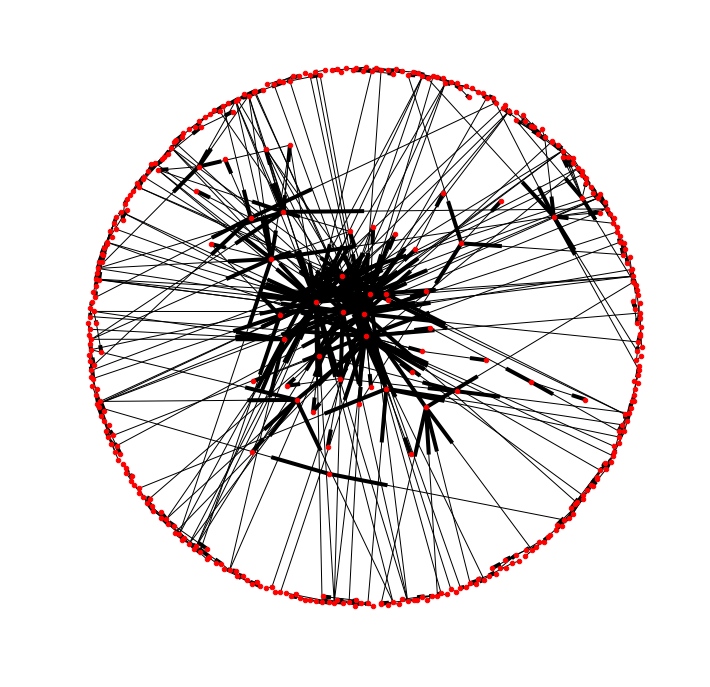

In [62]:
# Create network layout for visualizations
spring_pos = nx.spring_layout(g)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (12, 12)

plt.axis("off")
nx.draw_networkx(g, pos = spring_pos, with_labels = False, node_size = 20)

### Gráfico del grafo donde el tamaño es directamente proporcional a la cantidad de conexiones de un nodo y así como también la escala de colores del azul al rojo:

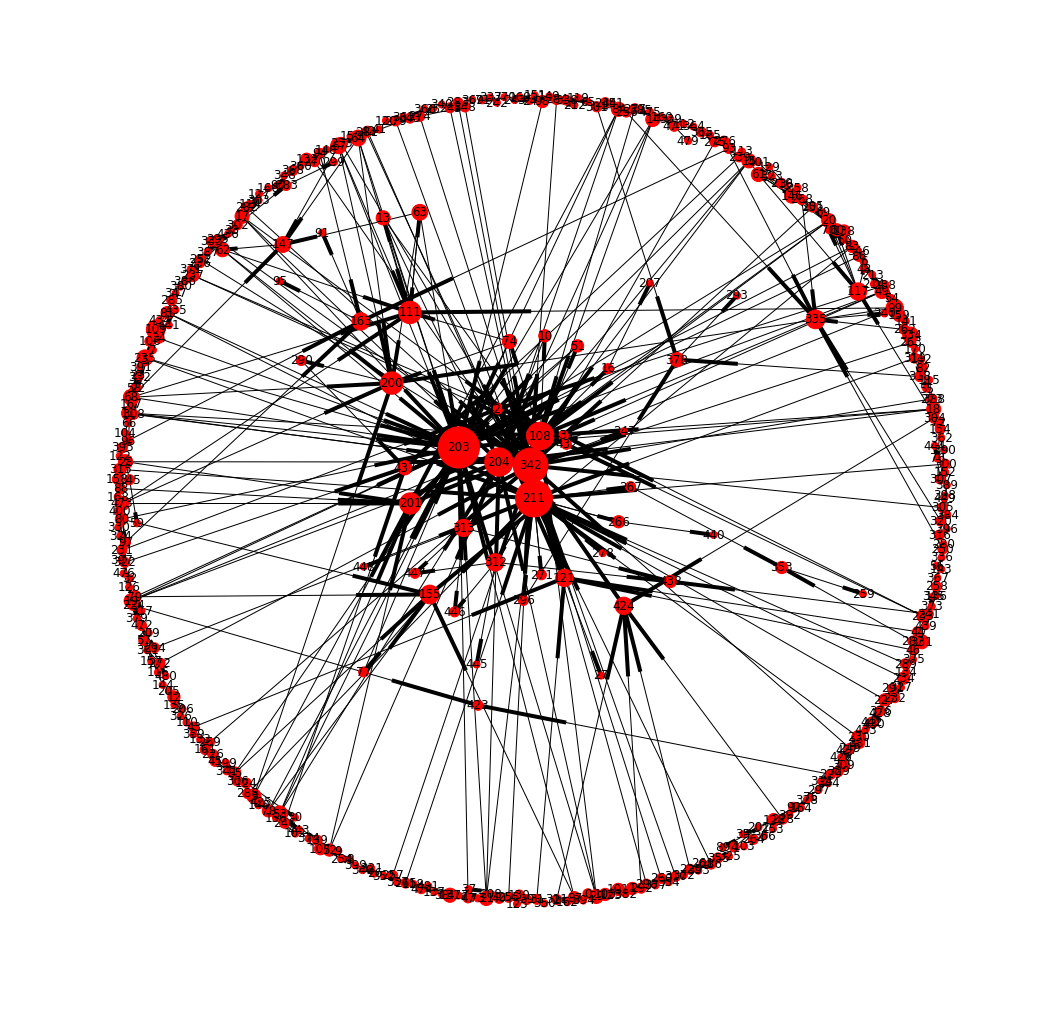

In [89]:
d = nx.degree(g)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (18, 18)

plt.axis("off")
nx.draw_networkx(g, pos = spring_pos, with_labels = True, nodelist=d.keys(), node_size=[v * 50 for v in d.values()])

### Ver nodos:

In [9]:
# View first five nodes
i = 0
for i in range(0,5):
    print(str(i + 1) + "- " + str(g.nodes(data=True)[i]))
    i = i + 1

1- ('1', {'favorites': 0, 'created_at': 'Wed May 31 21:14:07 +0000 2017', 'id': 870025622801838080, 'text': 'RT @KarinaAguatera: tamos ahí @sandynyordi #JuntosPorLaNovena https://t.co/x2kWrWLrS2', 'labels': ['Tweet']})
2- ('100', {'followers': 190, 'screen_name': 'KarinaAguatera', 'following': 964, 'name': '@JAKCARBONEROS', 'statuses': 1725, 'profile_image_url': 'http://pbs.twimg.com/profile_images/871221543908638720/x4FSyHJs_normal.jpg', 'location': 'montevideo', 'labels': ['User']})
3- ('2', {'favorites': 1, 'created_at': 'Wed May 31 21:24:58 +0000 2017', 'id': 870028352631054336, 'text': 'mi trabajo de parto duro menos q sacar las entradas para la última final. #JuntosPorLaNovena', 'labels': ['Tweet']})
4- ('0', {'favorites': 2, 'created_at': 'Wed May 31 21:03:11 +0000 2017', 'id': 870022870512152577, 'text': 'tamos ahí @sandynyordi #JuntosPorLaNovena https://t.co/x2kWrWLrS2', 'labels': ['Tweet']})
5- ('101', {'followers': 24, 'screen_name': 'sandynyordi', 'following': 183, 'name': 

### Ver ejes:

In [10]:
# View first five edges
i = 0
for i in range(0,5):
    print(str(i + 1) + "- " + str(g.edges(data=True)[i]))
    i = i + 1

1- ('1', '100', {'type': 'MENTIONS'})
2- ('1', '101', {'type': 'MENTIONS'})
3- ('100', '2', {'type': 'POSTS'})
4- ('100', '0', {'type': 'POSTS'})
5- ('0', '101', {'type': 'MENTIONS'})


In [21]:
# Tipos de nodos (Usuarios y Tweets)

# Count User nodes
#resultsUserNodes = cypher.run('ALGO', conn=connPar)

# Consulta networkx
#fish2 = (n for n,d in G.nodes_iter(data=True) if d['label']=='fish')

#resultsUserNodes.dataframe


### Calcular principales métricas sobre el grafo total:

In [12]:
# Tipo de grafo
esMultigrafo = g.is_multigraph()
esDireccional = g.is_directed()
esConectado = nx.is_connected(g.to_undirected())

# Número de nodos y conexiones
numNod = nx.number_of_nodes(g)
numEdg = nx.number_of_edges(g)

# Grados de un nodo (máximo, mínimo, promedio)
deg = nx.degree(g)
in_degrees  = g.in_degree()
out_degrees  = g.out_degree()

# Componentes conectados
if not esConectado:
    g2 = g.to_undirected() # saco direccionalidad

# Número de componentes conectados
numConComp = nx.number_connected_components(g2)

# Resumen
print("| -------------------------------------------- |")
if esMultigrafo:
    print("| Tipo de grafo: Multigrafo") 
if  not esMultigrafo: 
    print("| Tipo de grafo: Simple")

if esDireccional:
    print("| Direccional: Si") 
if  not esDireccional: 
    print("| Direccional: No")

if esConectado:
    print("| Conectado: Si") 
if  not esConectado: 
    print("| Conectado: No")
print("| -------------------------------------------- |")
print("| Número de nodos:", str(numNod))
print("| Número de conexiones:", str(numEdg))
print("| -------------------------------------------- |")
print("| Grado máximo entrada:", str(max(in_degrees.values())))
print("| Grado mínimo entrada:", str(min(in_degrees.values())))
print("| Grado promedio entrada:", str(sum(in_degrees.values())/len(deg.values())))
print("| -------------------------------------------- |")
print("| Grado máximo salida:", str(max(out_degrees.values())))
print("| Grado mínimo salida:", str(min(out_degrees.values())))
print("| Grado promedio salida:", str(sum(out_degrees.values())/len(deg.values())))
print("| -------------------------------------------- |")
print("| Grado máximo (no dir):", str(max(deg.values())))
print("| Grado mínimo (no dir):", str(min(deg.values())))
print("| Grado promedio (no dir):", str(sum(deg.values())/len(deg.values())))
print("| -------------------------------------------- |")
print("| Número total de componentes conectados: %d" % nx.number_connected_components(g2))
print("| -------------------------------------------- |")

| -------------------------------------------- |
| Tipo de grafo: Multigrafo
| Direccional: Si
| Conectado: No
| -------------------------------------------- |
| Número de nodos: 402
| Número de conexiones: 442
| -------------------------------------------- |
| Grado máximo entrada: 34
| Grado mínimo entrada: 0
| Grado promedio entrada: 1.099502487562189
| -------------------------------------------- |
| Grado máximo salida: 7
| Grado mínimo salida: 0
| Grado promedio salida: 1.099502487562189
| -------------------------------------------- |
| Grado máximo (no dir): 34
| Grado mínimo (no dir): 1
| Grado promedio (no dir): 2.199004975124378
| -------------------------------------------- |
| Número total de componentes conectados: 45
| -------------------------------------------- |


### Análisis sobre los componentes conectados, métricas en los subgrafos:

In [140]:
# Subgrafos de componentes conectados
g2_conComp = list(nx.connected_component_subgraphs(g2))

# Definir función con las métricas adentro
def metricas_subgrafos(subgrafo):
    
    # crear diccionario vacío
    dict = {}
    
    # métricas
    numNodos = nx.number_of_nodes(subgrafo) # número de nodos
    numConex = nx.number_of_edges(subgrafo) # número de conexiones
    grados = nx.degree(subgrafo) # grados
    maxGrado = max(grados.values()) # grado max
    minGrado = min(grados.values()) # grado min
    promGrado = sum(grados.values())/len(grados.values())
    diametro = nx.diameter(subgrafo) # diámetro
    radio = nx.radius(subgrafo) # radio
    excentricidad = nx.eccentricity(subgrafo) # excentricidad
    centro = nx.center(subgrafo) # centro
    periferia = nx.periphery(subgrafo) # periferia
    densidad = nx.density(subgrafo) # densidad
    
    # agregar métricas al diccionario
    dict['nodos'] = numNodos
    dict['conexiones'] = numConex
    dict['grados'] = grados
    dict['maxgrado'] = maxGrado
    dict['mingrado'] = minGrado
    dict['promGrado'] = promGrado
    dict['diámetro'] = diametro
    dict['radio'] = radio
    dict['excentricidad'] = excentricidad
    dict['centro'] = centro
    dict['periferia'] = periferia
    dict['densidad'] = densidad
    
    # retorno
    return dict

# Aplicar función metricas_subgrafos a todos los subgrafos
listaMetSubg = []

for subg in g2_conComp:
    subgMet = metricas_subgrafos(subg)
    listaMetSubg.append(subgMet)

# Ver métricas y plot del subgrafo principal: donde estań los nodos más importantes
import pandas as pd

for x in range(0,len(listaMetSubg)):
    for v in listaMetSubg[x].values():
        if(v == '211'):
            myDict = listaMetSubg[x]
            print(x)
         
# Hacer dataframe
df = pd.DataFrame()
df['Parámetro'] = myDict.keys()
df['Valores'] = myDict.values()

print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(df)
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

# Grados subgrafo
d = nx.degree(g2_conComp[x])

# Plot subgrafo
matplotlib.rcParams['figure.figsize'] = (5, 5)
plt.axis("off")
nx.draw_networkx(g2_conComp[x], pos = spring_pos, with_labels = True, nodelist=d.keys(), node_size=[v * 20 for v in d.values()])

5
6


TypeError: unsupported operand type(s) for +: 'dict' and 'int'

### Seleccionar el id, nombre y grado de los 10 nodos con más conexiones de salida:

In [41]:
# Select most output connected nodes

resultsDegOut = cypher.run('MATCH (n:User)-[r]->(m:Tweet) \
                            RETURN id(n) AS ID, n.screen_name AS NOMBRE, count(*) AS GRADO \
                            ORDER BY GRADO DESC LIMIT 10', conn=connPar)

resultsDegOut.dataframe


10 rows affected.


,ID,NOMBRE,GRADO
0,109,CesarGroba2016,7
1,211,Hebraicaymacabi,7
2,334,AKolender,5
3,117,alcaide943,4
4,131,carlosRocha1891,4
5,331,MSTM1215,4
6,108,daianab81,4
7,132,Macucha23,3
8,107,EduuCabrera19,3
9,159,DanielaBrandon,3


### Seleccionar el id, nombre y grado de los 10 nodos con más conexiones de entrada:

In [40]:
resultsDegIn = cypher.run('MATCH (n:User)<-[r]-(m:Tweet) \
                           RETURN id(n) AS ID, n.screen_name AS NOMBRE, count(*) AS GRADO \
                           ORDER BY GRADO DESC LIMIT 10', conn=connPar)

resultsDegIn.dataframe


10 rows affected.


,ID,NOMBRE,GRADO
0,203,Aguada_oficial,34
1,342,LUB_Uy,23
2,211,Hebraicaymacabi,20
3,204,RinconAguatero,16
4,108,daianab81,11
5,200,PasionAguatera,9
6,201,HAguatera,9
7,111,Somos_Aguada,8
8,424,elmarcadortv,6
9,335,alenb259,6


### Ver gráficos con los IDs con más conexiones de entrada:

93 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 81
Number of edges: 93
Average in degree:   1.1481
Average out degree:   1.1481


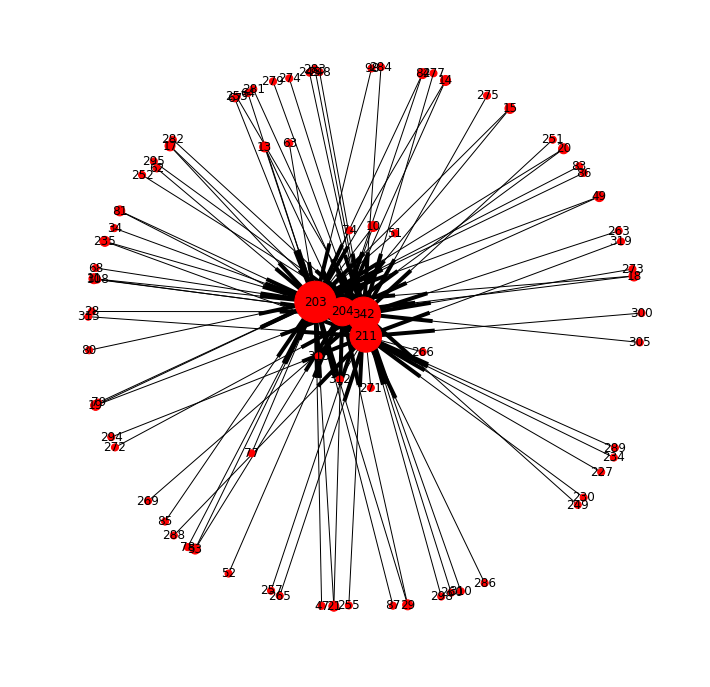

In [67]:
matplotlib.rcParams['figure.figsize'] = (12, 12)

resultsInDeg = cypher.run('MATCH a=(n:User)<-[r]-(m:Tweet) \
                           WHERE n.screen_name = "Aguada_oficial" \
                           OR n.screen_name = "LUB_Uy"\
                           OR n.screen_name = "Hebraicaymacabi" \
                           OR n.screen_name = "RinconAguatero" \
                           RETURN a;', conn=connPar)

# Create graph object from Neo4j
gInDeg = resultsInDeg.get_graph()

# View info
print(nx.info(gInDeg))

dInDeg = nx.degree(gInDeg)

# Plot graph
plt.axis("off")
nx.draw_networkx(gInDeg, pos = spring_pos, with_labels = True, nodelist=dInDeg.keys(), node_size=[v * 50 for v in dInDeg.values()])

### Ver gráficos con los IDs con más conexiones de salida:

19 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 22
Number of edges: 19
Average in degree:   0.8636
Average out degree:   0.8636


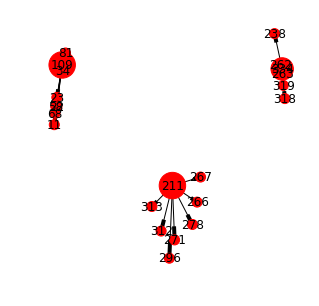

In [69]:
resultsOutDeg = cypher.run('MATCH a=(n:User)-[r]->(m:Tweet) \
                            WHERE n.screen_name = "CesarGroba2016" \
                            OR n.screen_name = "Hebraicaymacabi"\
                            OR n.screen_name = "AKolender" \
                            RETURN a;', conn=connPar)

# Create graph object from Neo4j
gOutDeg = resultsOutDeg.get_graph()

# View info
print(nx.info(gOutDeg))

dOutDeg = nx.degree(gOutDeg)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (5, 5)
plt.axis("off")
nx.draw_networkx(gOutDeg, pos = spring_pos, with_labels = True, nodelist=dOutDeg.keys(), node_size=[v * 100 for v in dOutDeg.values()])

### Seleccionar el id, nombre y grado de los 10 nodos con más conexiones (entrada y salida):

In [39]:
resultsDeg = cypher.run('MATCH (n:User)-[r]-(m:Tweet) \
                         RETURN id(n) AS ID, n.screen_name AS NOMBRE, count(*) AS GRADO \
                         ORDER BY GRADO DESC LIMIT 10', conn=connPar)

resultsDeg.dataframe


10 rows affected.


,ID,NOMBRE,GRADO
0,203,Aguada_oficial,34
1,211,Hebraicaymacabi,27
2,342,LUB_Uy,24
3,204,RinconAguatero,16
4,108,daianab81,15
5,200,PasionAguatera,10
6,111,Somos_Aguada,10
7,201,HAguatera,9
8,155,Castro_AnaLaura,7
9,335,alenb259,7


### Ver gráficos con los IDs con más conexiones (entrada y salida):

39 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 22
Number of edges: 19
Average in degree:   0.8636
Average out degree:   0.8636


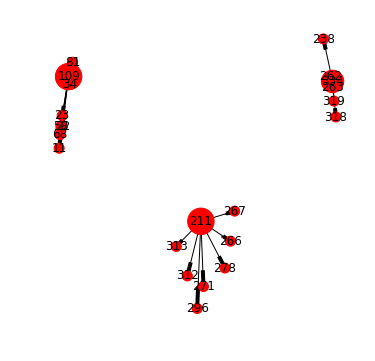

In [66]:
resultsInOutDeg = cypher.run('MATCH a=(n:User)-[r]-(m:Tweet) \
                              WHERE n.screen_name = "CesarGroba2016" \
                              OR n.screen_name = "Hebraicaymacabi"\
                              OR n.screen_name = "AKolender" \
                              RETURN a;', conn=connPar)

# Create graph object from Neo4j
gInOutDeg = resultsOutDeg.get_graph()

# View info
print(nx.info(gInOutDeg))

dInOutDeg = nx.degree(gInOutDeg)

# Plot graph
matplotlib.rcParams['figure.figsize'] = (6, 6)
plt.axis("off")
nx.draw_networkx(gInOutDeg, pos = spring_pos, with_labels = True, nodelist=dInOutDeg.keys(), node_size=[v * 100 for v in dInOutDeg.values()])

### Seleccionar todas las palabras de los tweets de los dos nodos más conectados para construir una nube de palabras:

In [76]:
# Nodo más conectado
resultsText1 = cypher.run('MATCH a=(n:User)-[r]-(m:Tweet) \
                          WHERE n.screen_name = "Aguada_oficial" \
                          RETURN DISTINCT(m.text);', conn=connPar)

# Open file connection to append resultsText
textAguadaOficial = open("AguadaOficialTweetText.txt", "a")
textAguadaOficial.write(str(resultsText1)+"/n")

# Segundo nodo más conectado
resultsText2 = cypher.run('MATCH a=(n:User)-[r]-(m:Tweet) \
                          WHERE n.screen_name = "Hebraicaymacabi" \
                          RETURN DISTINCT(m.text);', conn=connPar)

# Open file connection to append resultsText
textHebraicaymacabi = open("HebraicaymacabiTweetText.txt", "a")
textHebraicaymacabi.write(str(resultsText2)+"/n")


16 rows affected.
16 rows affected.


3191

Ver nodo más conectado:

In [90]:
resultsText1.dataframe

,(m.text)
0,RT @Mariog64: @Aguada_oficial @URUGUAYLATECAP ...
1,@cherrera88 @Aguada_oficial Eeeeeeeeee paaaara...
2,Es hoy #Juntosporlanovena 🙌🏼🙌🏼🙌🏼 @Aguada_ofici...
3,Y acá estamos! Vamos nosotros carajooo!!! #jun...
4,RT @Castro_AnaLaura: Es hoy #Juntosporlanovena...
5,40' para el salto inicial @Aguada_oficial vs @...
6,Es hoy @Aguada_oficial !!! Vamo arriba !! 💪🏽 \...
7,Es hoy @Aguada_oficial ! #JuntosPorLaNovena #a...
8,Es hoy!!! Trato de concentrarme en el trabajo ...
9,Ya no puedo mas... Tiene que ser hoy!!! #Junto...


Ver segundo nodo más conectado:

In [72]:
resultsText2.dataframe

,(m.text)
0,RT @Hebraicaymacabi: La gloria: ¡MacaBI! ¡HACI...
1,RT @hundilacom: Crónica de la victoria de @Heb...
2,RT @Hebraicaymacabi: Sacamos 26! Abrazate! Hac...
3,RT @susanarosano1: @Hebraicaymacabi Felicitaci...
4,RT @Hebraicaymacabi: Final! Ganó Macabi 82 a 5...
5,RT @MarioNBarbato: @OPetinatti @Hebraicaymacab...
6,RT @abifitcoach: @OPetinatti @Hebraicaymacabi ...
7,RT @Mariog64: @Aguada_oficial @URUGUAYLATECAP ...
8,RT @dobleyfalta_uy: #LUB | las mejores imágene...
9,@Hebraicaymacabi MacaBI CAMPEÓN! Que huevo Heb...


### Construir nube de palabras:

In [ ]:
from wordcloud import WordCloud, STOPWORDS
matplotlib.rcParams['figure.figsize'] = (15, 15)

#Convert all the required text into a single string here and store them in word_string
# you can specify fonts, stopwords, background color and other options

word_string1 = str(resultsText1)
word_string2 = str(resultsText2)

wordcloud1 = WordCloud(stopwords=STOPWORDS, max_font_size=50, background_color='white')
wordcloud1.generate(word_string1)

wordcloud2 = WordCloud(stopwords=STOPWORDS, max_font_size=50, background_color='white')
wordcloud2.generate(word_string2)

### Eliminar palabras no deseadas:

In [107]:
noise_words_set = {'@', 'https', '@Aguada_oficial', 'Hebraicaymacabi'}

for w in resultsText1:
    for a in  w.split():
        print("1",a)

#stuff = [' '.join(w for w in resultsText1 if w.lower() not in noise_words_set)
#         for resultsText1 in resultsText1]

#print(stuff)

AttributeError: 'list' object has no attribute 'split'

### Nube de palabras:

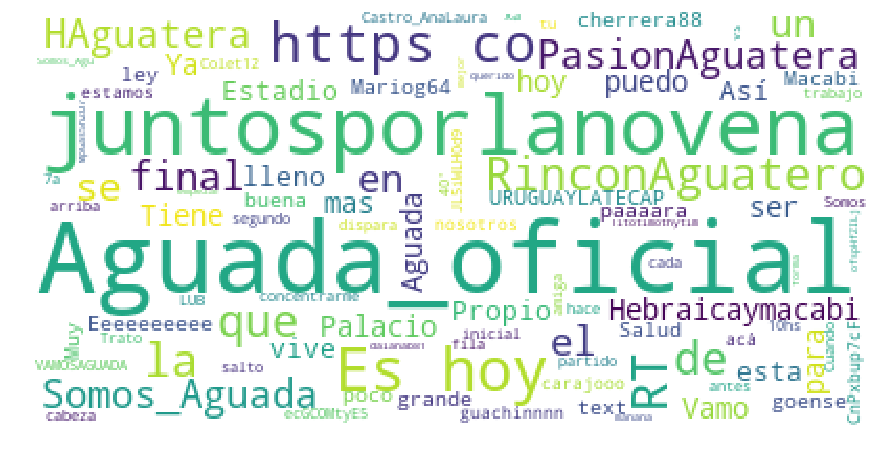

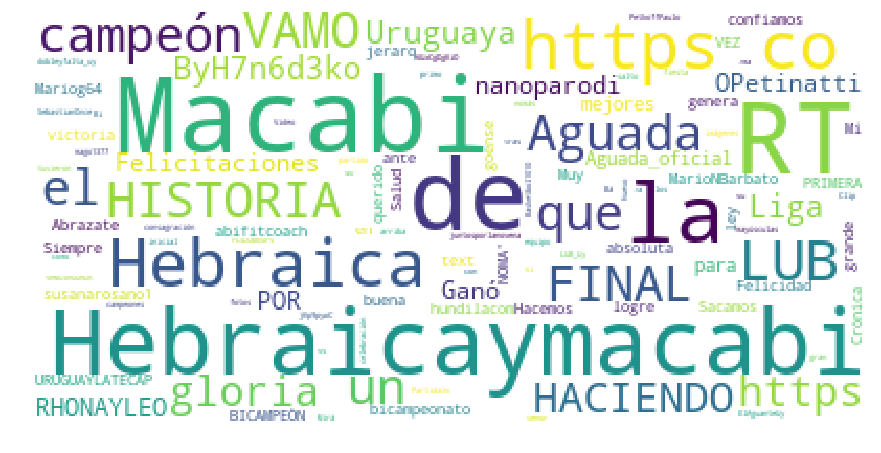

In [79]:
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

plt.imshow(wordcloud2)
plt.axis('off')
plt.show()